In [1]:
#Setting
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [29]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')
price = call_df('crawling_db.price_table')

In [91]:
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left',on='apartment_id'))

In [92]:
#전처리
df['apartment_floor_min'] = pd.to_numeric(df['apartment_floor_min'])
df['apartment_floor_max'] = pd.to_numeric(df['apartment_floor_max'])
df['school_students'] = pd.to_numeric(df['school_students'])
df['school_addr_town'] = df['school_addr_town'].apply(lambda x: re.split('\d',x)[0])

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8016 entries, 0 to 8015
Data columns (total 19 columns):
district_id              8016 non-null int64
apartment_id             8016 non-null int64
apartment_addr_town      8016 non-null object
apartment_builder        8016 non-null object
apartment_build_year     8016 non-null int64
apartment_build_month    8016 non-null int64
apartment_floor_min      8016 non-null int64
apartment_floor_max      8016 non-null int64
apartment_parking        8016 non-null float64
apartment_name           8016 non-null object
district_name            8016 non-null object
school_name              8016 non-null object
school_dist              8016 non-null int64
school_addr_district     8016 non-null int64
school_addr_town         8016 non-null object
school_students          7176 non-null float64
st_name                  8016 non-null object
st_dist                  8016 non-null float64
st_volume                8016 non-null int64
dtypes: float64(3), int64

In [94]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [95]:
#Encoding 전, 데이터 복사시키기
temp = df.copy()

In [96]:
#모든 범주형 자료를 label encoder를 이용하여 숫자형으로 변환

label_encoder.fit(temp.apartment_addr_town)
apartment_addr_town_encoded = label_encoder.transform(temp.apartment_addr_town)
temp.apartment_addr_town = apartment_addr_town_encoded

label_encoder.fit(temp.apartment_builder)
apartment_builder_encoded = label_encoder.transform(temp.apartment_builder)
temp.apartment_builder = apartment_builder_encoded

label_encoder.fit(temp.district_name)
district_name_encoded = label_encoder.transform(temp.district_name)
temp.district_name = district_name_encoded

label_encoder.fit(temp.school_name)
school_name_encoded = label_encoder.transform(temp.school_name)
temp.school_name = school_name_encoded

label_encoder.fit(temp.school_addr_town)
school_addr_town_encoded = label_encoder.transform(temp.school_addr_town)
temp.school_addr_town = school_addr_town_encoded

label_encoder.fit(temp.st_name)
st_name_encoded = label_encoder.transform(temp.st_name)
temp.st_name = st_name_encoded

temp.head(10)

,district_id,apartment_id,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,apartment_floor_min,apartment_floor_max,apartment_parking,apartment_name,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume
0,13,9738,146,1756,2004,12,10,25,1.34,상수두산위브,12,235,5,13,68,1012.0,137,0.001826,1
1,1,119219,8,2009,2020,9,7,35,1.71,개포래미안포레스트,0,56,2,1,10,492.0,97,0.009325,1
2,1,107513,8,2102,2003,3,10,10,2.27,개포상지리츠빌,0,27,4,1,10,837.0,32,0.002699,1
3,1,960,8,1592,1982,11,5,5,0.49,개포주공1단지,0,26,1,1,146,131.0,32,0.007869,1
4,1,1289,8,1592,1982,11,5,5,0.40,개포주공4단지,0,346,1,1,10,455.0,13,0.004453,1
5,1,1298,8,1592,1983,10,13,14,0.97,개포주공5단지,0,346,3,1,10,455.0,13,0.001978,1
6,1,1303,8,1592,1983,10,13,15,0.28,개포주공6단지,0,346,2,1,10,455.0,13,0.001076,1
7,1,1307,8,1592,1983,10,15,15,0.44,개포주공7단지,0,346,2,1,10,455.0,13,0.002930,1
8,1,103385,8,3515,1986,7,9,9,0.00,개포현대(200동),0,56,1,1,10,492.0,97,0.005728,1
9,1,10329,8,3539,1988,9,9,9,0.00,개포현대2차(220동),0,56,1,1,10,492.0,97,0.006298,1


In [97]:
#학생 수에 갑자기 na 값이 생겨서 모두 0 으로 대체
temp = temp.fillna(0.0)

In [98]:
#Clustering은 분산에 민감하므로, 숫자형 자료는 scaling 해준다.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [99]:
temp_for_scaling = temp[['apartment_floor_min','apartment_floor_max','apartment_parking','school_students','st_dist']]
print(ss.fit(temp_for_scaling))
temp_scaled = ss.transform(temp_for_scaling)
temp_scaled = pd.DataFrame(temp_scaled,columns=temp_for_scaling.columns)
temp = pd.concat([temp[['apartment_addr_town', 'apartment_builder','apartment_build_year','apartment_build_month','district_name','school_name','school_dist','school_addr_district','school_addr_town','st_name','st_volume']], temp_scaled], axis=1)
temp.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,district_name,school_name,school_dist,school_addr_district,school_addr_town,st_name,st_volume,apartment_floor_min,apartment_floor_max,apartment_parking,school_students,st_dist
0,146,1756,2004,12,12,235,5,13,68,137,1,0.145925,1.883620,0.394642,0.697978,-1.035423
1,8,2009,2020,9,0,56,2,1,10,97,1,-0.439529,3.333310,0.940510,-0.500065,0.953997
2,8,2102,2003,3,0,27,4,1,10,32,1,0.145925,-0.290915,1.766689,0.294790,-0.803781
3,8,1592,1982,11,0,26,1,1,146,32,1,-0.829831,-1.015759,-0.859379,-1.331784,0.567727
4,8,1592,1982,11,0,346,1,1,10,13,1,-0.829831,-1.015759,-0.992158,-0.585311,-0.338445


# Modeling 

In [100]:
#K-means 군집화
from sklearn.cluster import KMeans
model = KMeans(n_clusters=8)
model.fit(temp)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [101]:
#군집 정보를 label에 입력
df['label'] = model.fit_predict(temp)
temp['label'] = model.fit_predict(temp)

In [102]:
temp

,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,district_name,school_name,school_dist,school_addr_district,school_addr_town,st_name,st_volume,apartment_floor_min,apartment_floor_max,apartment_parking,school_students,st_dist,label
0,146,1756,2004,12,12,235,5,13,68,137,1,0.145925,1.883620,0.394642,0.697978,-1.035423,7
1,8,2009,2020,9,0,56,2,1,10,97,1,-0.439529,3.333310,0.940510,-0.500065,0.953997,4
2,8,2102,2003,3,0,27,4,1,10,32,1,0.145925,-0.290915,1.766689,0.294790,-0.803781,4
3,8,1592,1982,11,0,26,1,1,146,32,1,-0.829831,-1.015759,-0.859379,-1.331784,0.567727,7
4,8,1592,1982,11,0,346,1,1,10,13,1,-0.829831,-1.015759,-0.992158,-0.585311,-0.338445,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,175,2895,2004,3,24,131,10,25,163,95,2,-0.439529,-0.725821,0.011059,-0.677468,-0.196511,5
8012,277,1560,2019,12,24,0,0,25,0,226,1,0.926530,0.288961,-0.756106,-1.633599,0.701573,7
8013,277,501,2014,7,24,478,2,25,124,260,1,-0.634680,-0.870790,-0.387277,-1.069136,-1.160169,6
8014,277,1695,2010,5,24,224,16,25,74,226,1,1.511984,0.868837,0.925757,-0.106093,0.554395,7


<Figure size 432x288 with 0 Axes>

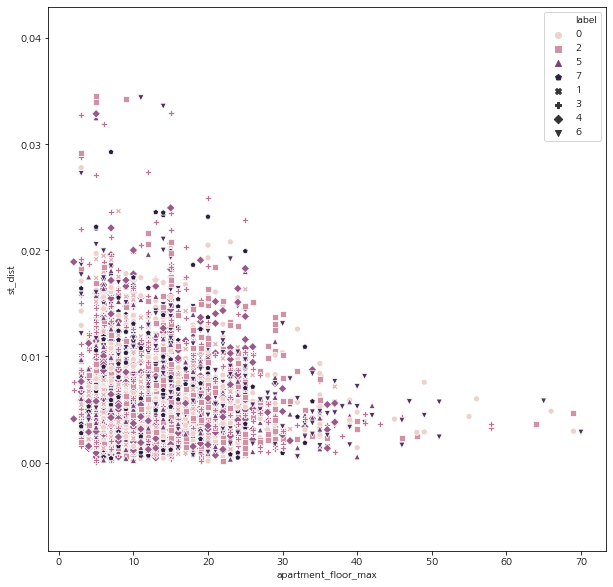

In [103]:
#어느정도의 군집은 일어났으나..
fig = plt.figure()
plt.subplots(figsize=(10,10))
sns.scatterplot(x='apartment_floor_max', 
                y='st_dist', 
                hue='label', # different colors by group
                style='label', # different shapes by group
                data=df)

In [104]:
#강남끼리 잘 묶인걸로 보아 이것도 괜찮은 것 같고..
df[df['label'] == 7].head(15)

,district_id,apartment_id,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,apartment_floor_min,apartment_floor_max,apartment_parking,apartment_name,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume,label
22,1,667,개포동,우성건설(주),1984,12,15,15,1.11,우성3차,강남구,서울개일초등학교,4,1,개포로,837.0,매봉역,0.006596,1,7
23,1,770,개포동,우성건설(주),1987,11,5,5,1.00,우성6차,강남구,서울포이초등학교,3,1,개포로,434.0,구룡역,0.011730,1,7
24,1,818,개포동,우성건설(주),1987,9,9,9,0.52,우성8차,강남구,서울개일초등학교,7,1,개포로,837.0,구룡역,0.001291,1,7
25,1,102377,개포동,우찬종합건설(주),2006,6,6,6,1.53,우찬현대(101),강남구,서울구룡초등학교,6,1,개포로,492.0,매봉역,0.007590,1,7
26,1,102378,개포동,우찬종합건설(주),2006,6,6,6,1.50,우찬현대(102),강남구,서울구룡초등학교,6,1,개포로,492.0,매봉역,0.007492,1,7
27,1,102379,개포동,우찬종합건설(주),2006,6,6,6,1.50,우찬현대(103),강남구,서울구룡초등학교,6,1,개포로,492.0,매봉역,0.007579,1,7
35,1,105408,논현동,아시아건설주식회사,2009,8,7,7,1.85,골든캐슬,강남구,서울언북초등학교,10,1,삼성로,1882.0,학동역,0.006378,1,7
36,1,26196,논현동,씨앤엔종합건설(주),2004,9,6,6,2.06,그랑디오스,강남구,서울학동초등학교,5,1,선릉로,485.0,선정릉역,0.004464,2,7
45,1,18,논현동,신동아건설(주),1997,7,9,13,1.06,논현신동아파밀리에,강남구,서울논현초등학교,14,1,강남대로,339.0,신사역,0.001758,1,7
48,1,26416,논현동,에스케이건설(주),2007,12,3,4,1.94,논현아펠바움1차,강남구,서울학동초등학교,7,1,선릉로,485.0,학동역,0.001976,1,7


In [105]:
#다시 price 붙이기
df = df[['apartment_id','apartment_name','label']]
df = df.merge(price, how='left', on='apartment_id')
df.head(20)

,apartment_id,apartment_name,label,price_id,area,period,year,month,amount,amount_original
0,9738,상수두산위브,6,248300.0,104㎡,2020.03,2020.0,3.0,1.200000e+09,12억
1,9738,상수두산위브,6,248301.0,104㎡,2020.02,2020.0,2.0,1.200000e+09,12억
2,9738,상수두산위브,6,248302.0,104㎡,2019.12,2019.0,12.0,1.035000e+09,"10억 3,500"
3,9738,상수두산위브,6,248303.0,104㎡,2019.11,2019.0,11.0,1.025000e+09,"10억 2,500"
4,9738,상수두산위브,6,248304.0,104㎡,2019.10,2019.0,10.0,9.600000e+08,"9억 6,000"
5,9738,상수두산위브,6,248305.0,104㎡,2019.08,2019.0,8.0,9.200000e+08,"9억 2,000"
6,9738,상수두산위브,6,248306.0,104㎡,2019.06,2019.0,6.0,8.650000e+08,"8억 6,500"
7,9738,상수두산위브,6,248307.0,104㎡,2019.02,2019.0,2.0,7.900000e+08,"7억 9,000"
8,9738,상수두산위브,6,248308.0,104㎡,2018.12,2018.0,12.0,9.750000e+08,"9억 7,500"
9,9738,상수두산위브,6,248309.0,104㎡,2018.08,2018.0,8.0,8.050000e+08,8억 500


In [107]:
# period => datetime 형태로 변환. 시각화에 용이.
pd.plotting.register_matplotlib_converters() # datetime 형태를 시각화에 사용
df['time_period'] = df['period'].apply(lambda x: pd.to_datetime(x, format='%Y.%m'))

In [109]:
temp = df.copy()
temp

,apartment_id,apartment_name,label,price_id,area,period,year,month,amount,amount_original,time_period
0,9738,상수두산위브,6,248300.0,104㎡,2020.03,2020.0,3.0,1.200000e+09,12억,2020-03-01
1,9738,상수두산위브,6,248301.0,104㎡,2020.02,2020.0,2.0,1.200000e+09,12억,2020-02-01
2,9738,상수두산위브,6,248302.0,104㎡,2019.12,2019.0,12.0,1.035000e+09,"10억 3,500",2019-12-01
3,9738,상수두산위브,6,248303.0,104㎡,2019.11,2019.0,11.0,1.025000e+09,"10억 2,500",2019-11-01
4,9738,상수두산위브,6,248304.0,104㎡,2019.10,2019.0,10.0,9.600000e+08,"9억 6,000",2019-10-01
...,...,...,...,...,...,...,...,...,...,...,...
460232,26741,중화동양엔파트,6,458242.0,105B1㎡,2015.03,2015.0,3.0,3.670000e+08,"3억 6,700",2015-03-01
460233,26741,중화동양엔파트,6,458243.0,105B1㎡,2015.01,2015.0,1.0,3.670000e+08,"3억 6,700",2015-01-01
460234,26741,중화동양엔파트,6,458244.0,105B1㎡,2014.11,2014.0,11.0,3.670000e+08,"3억 6,700",2014-11-01
460235,26741,중화동양엔파트,6,458245.0,105B1㎡,2011.09,2011.0,9.0,3.900000e+08,"3억 9,000",2011-09-01


In [126]:
#결측치 제거
temp = temp.dropna()
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457904 entries, 0 to 460235
Data columns (total 5 columns):
apartment_name    457904 non-null object
label             457904 non-null int32
area              457904 non-null int64
amount            457904 non-null float64
time_period       457904 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 19.2+ MB


In [116]:
#필요한 데이터만 추출
temp = temp.drop(['apartment_id','price_id','period','year','month','amount_original'],axis=1)

In [123]:
# area => 숫자가 아닌 무언가가 처음 나오는 것 기준으로 앞의 내용
import re
temp['area'] = temp['area'].apply(lambda x: int(re.split('\D',x)[0]))

In [124]:
temp[(temp['time_period']=='2020-03-01') & (temp['label']==6)]

,apartment_name,label,area,amount,time_period
0,상수두산위브,6,104,1.200000e+09,2020-03-01
289,개포주공1단지,6,41,2.030000e+09,2020-03-01
491,개포주공1단지,6,49,2.350000e+09,2020-03-01
593,개포주공1단지,6,50,1.900000e+09,2020-03-01
1430,개포주공6단지,6,68,1.585000e+09,2020-03-01
...,...,...,...,...,...
455583,두산위브,6,107,7.000000e+08,2020-03-01
456320,은평뉴타운우물골5단지,6,116,7.450000e+08,2020-03-01
457708,두원,6,79,3.820000e+08,2020-03-01
457770,두원,6,108,4.730000e+08,2020-03-01


In [125]:
#사용자가 원하는 아파트 입력
your_apart = input('아파트 이름을 입력해주세요: ')

아파트 이름을 입력해주세요: 상수두산위브


In [127]:
#사용자가 원하는 면적 입력
your_area = int(input('면적을 입력해 주세요(m2 단위): '))

면적을 입력해 주세요(m2 단위): 104


In [141]:
#해당 아파트와 면적이 해당하는 cluster 추출하고, 그 cluster 해당하는 모든 아파트 가격들을 모아 새로운 변수를 생성
group_name = temp[(temp['apartment_name']==your_apart) & (temp['area'] == your_area)].label[1]
temp_for_arima = temp[temp['label']== group_name]
temp_for_arima

,apartment_name,label,area,amount,time_period
0,상수두산위브,6,104,1.200000e+09,2020-03-01
1,상수두산위브,6,104,1.200000e+09,2020-02-01
2,상수두산위브,6,104,1.035000e+09,2019-12-01
3,상수두산위브,6,104,1.025000e+09,2019-11-01
4,상수두산위브,6,104,9.600000e+08,2019-10-01
...,...,...,...,...,...
460231,중화동양엔파트,6,105,5.950000e+08,2019-11-01
460232,중화동양엔파트,6,105,3.670000e+08,2015-03-01
460233,중화동양엔파트,6,105,3.670000e+08,2015-01-01
460234,중화동양엔파트,6,105,3.670000e+08,2014-11-01


In [142]:
#이 데이터로 이제 시계열 분석을 진행해야 한다. 필요없는 자료들은 역시 제거한다
temp_for_arima = temp_for_arima.drop(['apartment_name','label','area'],axis=1)
temp_for_arima = temp_for_arima[['time_period','amount']]
temp_for_arima

,time_period,amount
0,2020-03-01,1.200000e+09
1,2020-02-01,1.200000e+09
2,2019-12-01,1.035000e+09
3,2019-11-01,1.025000e+09
4,2019-10-01,9.600000e+08
...,...,...
460231,2019-11-01,5.950000e+08
460232,2015-03-01,3.670000e+08
460233,2015-01-01,3.670000e+08
460234,2014-11-01,3.670000e+08


In [145]:
temp_for_arima.sort_values(by='time_period',ascending=True)

,time_period,amount
21735,2006-01-01,7.500000e+08
401879,2006-01-01,1.107300e+08
327031,2006-01-01,4.900000e+08
326976,2006-01-01,2.750000e+08
160076,2006-01-01,6.200000e+07
...,...,...
85153,2020-04-01,1.600000e+08
176168,2020-04-01,6.200000e+08
172075,2020-04-01,7.250000e+08
207872,2020-04-01,1.305000e+09


In [151]:
temp_for_arima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85971 entries, 0 to 460235
Data columns (total 2 columns):
time_period    85971 non-null datetime64[ns]
amount         85971 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 MB


In [154]:
#밑에서 안되는걸 확인했으니, 혹여나 평균으로 한번 구해봅니다
temp_for_arima = temp_for_arima.groupby(temp_for_arima['time_period']).mean()
temp_for_arima

,amount
time_period,
2006-01-01,3.461198e+08
2006-02-01,3.499481e+08
2006-03-01,3.492036e+08
2006-04-01,3.543284e+08
2006-05-01,3.078849e+08
...,...
2019-12-01,7.731110e+08
2020-01-01,6.859518e+08
2020-02-01,7.174344e+08


In [172]:
#19년 12월까지의 데이터만 train하고, 나머지 20년 1~4월까지는 test하기 위해 쪼갠다
temp_for_train = temp_for_arima[0:len(temp_for_arima)-4]
temp_for_test = temp_for_arima[len(temp_for_arima)-4:len(temp_for_arima)]

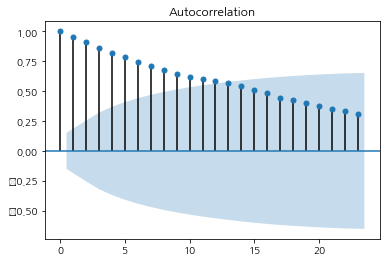

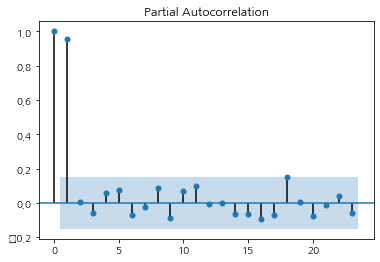

In [173]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(temp_for_train)
plot_pacf(temp_for_train)
plt.show()

In [174]:
#혹시나 하여 돌려보겠습니다
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(temp_for_train, order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.amount   No. Observations:                  167
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3072.692
Method:                       css-mle   S.D. of innovations       23684314.122
Date:                Sat, 02 May 2020   AIC                           6151.385
Time:                        10:29:59   BIC                           6160.739
Sample:                    02-01-2006   HQIC                          6155.181
                         - 12-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.557e+06   1.51e+06      1.688      0.093   -4.12e+05    5.53e+06
ma.L1.D.amount    -0.1747      0.077     -2.264      0.025      -0.326      -0.023
                                    

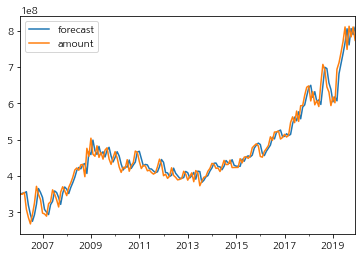

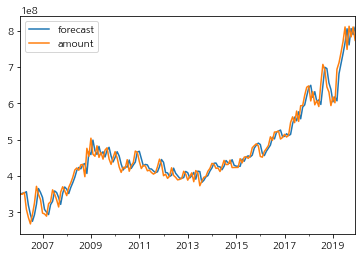

In [175]:
model_fit.plot_predict()

In [210]:
fore = model_fit.forecast(steps=4)
arima = pd.DataFrame(fore[0])
arima.columns = ['arima']
arima.index = temp_for_test.index
arima

,arima
time_period,
2020-01-01,7.819461e+08
2020-02-01,7.845029e+08
2020-03-01,7.870597e+08
2020-04-01,7.896166e+08


In [213]:
#결과는 조금 속상하군요
result = pd.concat([temp_for_test,arima],axis=1)
result.columns = ['real','model']
result

,real,model
time_period,,
2020-01-01,6.859518e+08,7.819461e+08
2020-02-01,7.174344e+08,7.845029e+08
2020-03-01,6.889863e+08,7.870597e+08
2020-04-01,6.672024e+08,7.896166e+08
